In [2]:
import pandas as pd
import statsmodels.api as sm

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Reading data

df = pd.read_csv('../data/airbnb_paris_clean_feat.csv')
X = df.drop('price',axis=1)
y = df.price

In [4]:
class Assumption_Tester_OLS:
    """
    X - Pandas DataFrame with numerical values. Independent Variable
    y - Series with numerical values. Dependent Variable
    
    Tests a linear regression on the model to see if assumptions are being met

    """
    
    from sklearn.linear_model import LinearRegression
    
    def __init__(self, X,y):
        from numpy import ndarray
        from pandas import concat
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series

        if type(X) == ndarray:
            self.features = ['X'+str(feature+1) for feature in range(X.shape[1])]
        elif type(X) == DataFrame:
            self.features=X.columns.to_list()
        else:
            print('Expected numpy array or pandas dataframe as X')
            return
        if type(y) == ndarray:
            self.output = 'y'
        elif type(y) == DataFrame:
            self.output=y.columns[0]
        elif type(y) == Series:
            self.output=y.name
        else:
            print('Expected numpy array or pandas dataframe as X')
            return

        self.X = X.values if type(X)==DataFrame else X
        self.y=y.iloc[:,0].values if type(y)==DataFrame else y.values if type(y)==Series else y
        
        self.model='not built yet'
        self.r2=0
        self.results={'Satisfied':[],'Potentially':[],'Violated':[]}
    
    def fit_model(self):
        from sklearn.linear_model import LinearRegression
        
        print('Fitting linear regression')        
        
        #Multi-threading when needed
        if self.X.shape[0] > 100000:
            self.model = LinearRegression(n_jobs=-1)
        else:
            self.model = LinearRegression()
        self.model.fit(self.X, self.y)
        
        self.predictions = self.model.predict(self.X)
        self.resid = self.y - self.predictions
        
        
    def build_model(self):
        self.fit_model()
        
        # Returning linear regression R^2 and coefficients before performing diagnostics
        self.r2 = self.model.score(self.X, self.y)
        print()
        print('R^2:', self.r2, '\n')
        print('Coefficients')
        print('-------------------------------------')
        print('Intercept:', self.model.intercept_)
        for idx,feature in enumerate(self.model.coef_):
            print(f'{self.features[idx]}: {round(feature,2)}')

    def linearity(self):
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        from pandas import concat
        from numpy import arange
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series        
        import seaborn as sns
        sns.set()
        import matplotlib.pyplot as plt
        
        if type(self.model)==str:
            self.fit_model()
        
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.regplot(self.y,self.predictions, fit_reg=False)
        
        # Plotting the diagonal line
        line_coords = arange(min(self.y.min(),self.predictions.min()), max(self.y.max(),self.predictions.max()))
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term \n\t\tor using box-cox transformation to make X or y follow normal distribution')
        
        print('\n\n\nBuilding a correlation table')
        print('\n=======================================================================================')
        df=concat([DataFrame(self.X),Series(self.y)],axis=1)
        df.columns=self.features+[self.output]
        df_corr=df[df.nunique()[df.nunique()>2].index].corr()[self.output].drop(self.output)
        
        print(f'\nParameters that are most likely VIOLATE linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)<0.25])

        print(f'\nParameters that are most likely FOLLOW linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)>=0.25])
        
        
        if df_corr[abs(df_corr)<0.25].shape[0]==0:
            self.results['Satisfied'].append('Linearity')
        elif df_corr[abs(df_corr)>=0.25].shape[0]==0:
            self.results['Violated'].append('Linearity')
        else:
            self.results['Potentially'].append('Linearity')
        
    def multicollinearity(self):
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
        import matplotlib.pyplot as plt
        import seaborn as sns
        from pandas.core.frame import DataFrame
        sns.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 2: Little to no multicollinearity among predictors')
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(DataFrame(self.X, columns=self.features).corr(), annot=len(self.features)<10, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True))
        plt.title('Correlation of Variables')
        plt.show()
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
        # Gathering the VIF for each variable
        vifs = {i:VIF(self.X, idx) for idx,i in enumerate(self.features)}
        vifs = dict(sorted(vifs.items(), key=lambda x: x[1], reverse=True))
        for key, vif in vifs.items():
            print(f'{key}: {vif}')
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in vifs.values() if vif > 10])
        definite_multicollinearity = sum([1 for vif in vifs.values() if vif > 100])
        print()
        print(f'{possible_multicollinearity} cases of possible multicollinearity')
        print(f'{definite_multicollinearity} cases of definite multicollinearity')
        print()
        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
                self.results['Satisfied'].append('Multicollinearity')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
                self.results['Potentially'].append('Multicollinearity')

        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
            self.results['Violated'].append('Multicollinearity')
            

    
    def autocorrelation(self):
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson        
        
        if type(self.model)==str:
            self.fit_model()
        print('\n=======================================================================================')
        print('Assumption 3: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(self.resid)
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')
            self.results['Satisfied'].append('Autocorrelation')
            

    def homoskedasticity(self,p_value_thresh=0.05):
        """
        Homoskedasticity: Assumes that the errors exhibit constant variance
        """
        
        from statsmodels.stats.diagnostic import het_breuschpagan
        
        import matplotlib.pyplot as plt
        import seaborn
        from numpy import repeat
        seaborn.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 4: Homoskedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=range(self.X.shape[0]), y=self.resid, alpha=0.5)
        plt.plot(repeat(0, self.X.shape[0]), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroskedasticity is apparent, confidence intervals and predictions will be affected')        
        print('\nConsider removing outliers and preprocessing features - nonlinear transformation can help')
        
        lnames=['Lagrange Multiplier', 'pvalue for LM','F stats','pvalue for Fstats']
        display({lnames[idx]:het_breuschpagan(self.resid,self.X)[idx] for idx in range(4)})
        if het_breuschpagan(self.resid,self.X)[3] < p_value_thresh:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption potentially not satisfied', '\n')
            self.results['Potentially'].append('Autocorrelation')
        else:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption satisfied', '\n')
            self.results['Satisfied'].append('Autocorrelation')

       
        
    def normality_resid(self,p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        from scipy.stats import probplot
        import pylab
        import matplotlib.pyplot as plt
        import seaborn as sns
        from numpy import quantile,logical_or
        sns.set()

        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 5: The error terms are kinda normally distributed')
        print()
        print('Using the Anderson-Darling test for normal distribution')
        # Performing the test on the residuals
        p_value = normal_ad(self.resid)[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(self.resid)
        plt.show()
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
            self.results['Satisfied'].append('Normality')
        else:
            print('Assumption not satisfied')
            self.results['Violated'].append('Normality')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
    
    
        print('Building a probability plot')
        quantiles=probplot(self.resid, dist='norm', plot=pylab);
        plt.show()
        qqq=(quantiles[0][1]-quantiles[0][1].mean())/quantiles[0][1].std()-quantiles[0][0]
        q75=quantile(qqq,0.75)
        q25=quantile(qqq,0.25)

        outliers_share=(logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()/qqq.shape[0]).round(3)
        if outliers_share<0.005:
            print('Assumption can be considered as satisfied.')
            self.results['Satisfied'].append('Sub-Normality')
        elif outliers_share<0.05:
            self.results['Potentially'].append('Sub-Normality')
            print(f'\nIn your dataset you quite fat tails. You have {outliers_share} potential outliers ({logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()} rows)')
        else:
            print(f'\nIn fact outliers are super significant. Probably it is better to split your dataset into 2 different ones.')
            self.results['Violated'].append('Sub-Normality')


    def run_all(self):
        self.build_model()
        self.linearity()
        self.multicollinearity()
        self.autocorrelation()
        self.homoskedasticity()
        self.normality_resid()
        display(self.results)

In [5]:
assumptions = Assumption_Tester_OLS(X,y)

Fitting linear regression

R^2: 0.4304100519025337 

Coefficients
-------------------------------------
Intercept: 0.007855150642320285
accommodates: 0.52
bathrooms: 0.3
bedrooms: 0.19
guests_included: 0.16
availability_365: 0.12
number_of_reviews: -0.1
property_type_Hotel: 0.11
property_type_Serviced apartment: 0.12
room_type_Shared room: -0.13
cancellation_policy_super_strict_30: 0.21

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


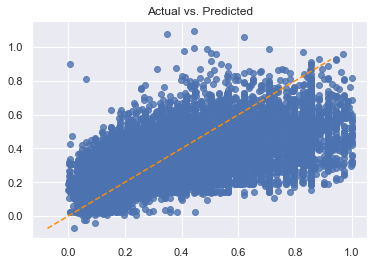

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with price


number_of_reviews    0.035526
Name: price, dtype: float64


Parameters that are most likely FOLLOW linearity assumption and their correlation with price


accommodates        0.540338
bathrooms           0.387262
bedrooms            0.495620
guests_included     0.313471
availability_365    0.287121
Name: price, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


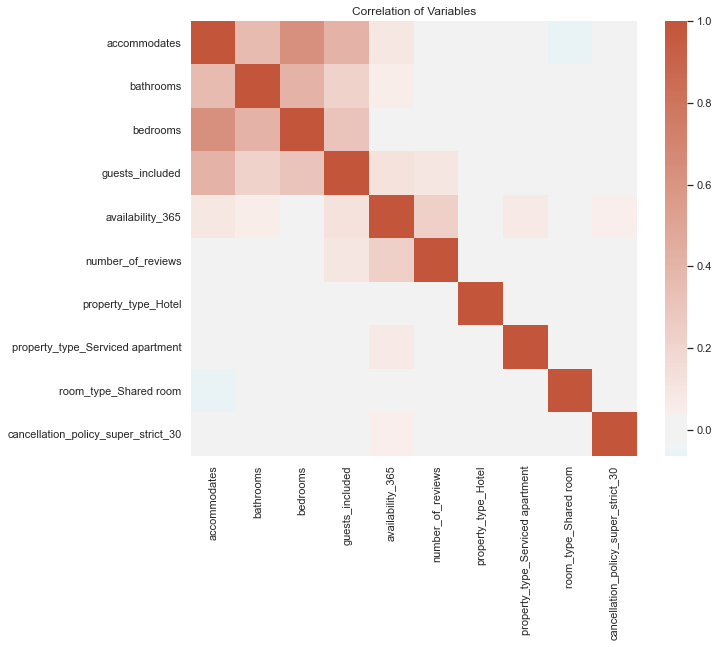

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
accommodates: 5.646882975213057
bedrooms: 5.166487556960563
bathrooms: 4.651661963229325
availability_365: 1.5202555043436508
guests_included: 1.5062085576627433
number_of_reviews: 1.3103093437511244
room_type_Shared room: 1.0146140963533852
property_type_Serviced apartment: 1.013915854401782
cancellation_policy_super_strict_30: 1.004585330310705
property_type_Hotel: 1.004459216750857

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

Assumption 3: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9602326926002922
Little to no autocorrelation 

Assumpt

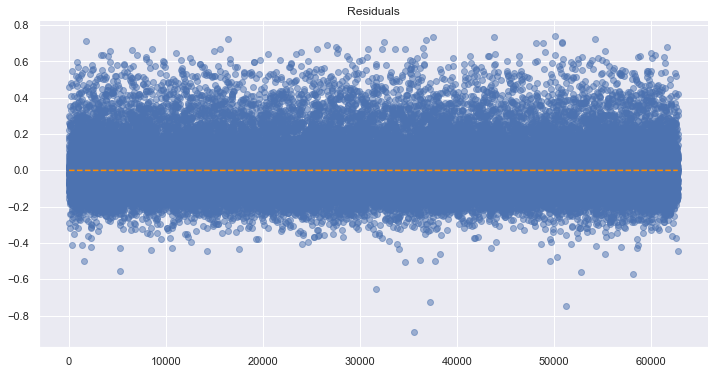

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 13203.926727677039,
 'pvalue for LM': 0.0,
 'F stats': 1671.6607126514311,
 'pvalue for Fstats': 0.0}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


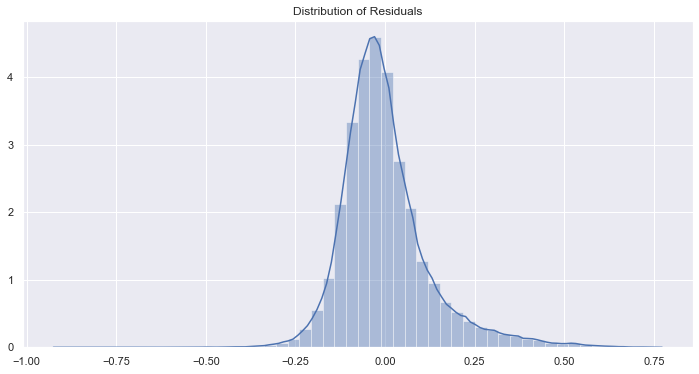


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


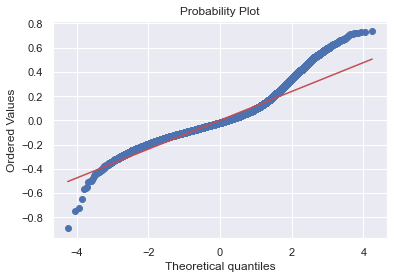


In your dataset you quite fat tails. You have 0.023 potential outliers (1457 rows)


{'Satisfied': ['Multicollinearity',
  'Autocorrelation',
  'Multicollinearity',
  'Autocorrelation'],
 'Potentially': ['Linearity',
  'Autocorrelation',
  'Sub-Normality',
  'Linearity',
  'Autocorrelation',
  'Sub-Normality'],
 'Violated': ['Normality', 'Normality']}

In [7]:
assumptions.run_all()